In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

In [13]:
app_train = pd.read_csv("application_train.csv").reset_index(drop = True)
app_test = pd.read_csv("application_test.csv").reset_index(drop = True)
bureau = pd.read_csv("bureau.csv").reset_index(drop = True)
bureau_balance = pd.read_csv("bureau_balance.csv").reset_index(drop = True)


In [4]:
data_sets = dict(app_train=app_train, 
#                  app_test=app_test,
                 bureau=bureau, 
                 bureau_balance=bureau_balance
                )


检查那些缺失值过多的列，如果缺失值占比大于95%该列需要被删除

In [5]:

for ds_name, ds in data_sets.items():
    total_rows = ds.shape[0]
    null_count = 0
    to_del = []
    for col in ds.columns:
        if ds[col].isnull().sum()/total_rows > 0.95:
            print(col)
            to_del.append(col)
            null_count += 1
            
    ds.drop(to_del, inplace=True)

    print("%s columns of %s need to be dropped because of too many null values" % (null_count, ds_name))

0 columns of app_train need to be dropped because of too many null values
0 columns of bureau need to be dropped because of too many null values
0 columns of bureau_balance need to be dropped because of too many null values


检查是否存在单值的列，有就去除

In [6]:
for ds_name, ds in data_sets.items():
    to_del = []
    one_value_count = 0
    for col in ds.columns:
        uv = ds[col].unique()
        if len(list(uv)) <= 1:
            if np.any(ds[col].isnull()):
                print("yes")
                break
            print("%s has %s" % (col, uv))
            to_del.append(col)
            one_value_count += 1
    if to_del:
        ds.drop(to_del, axis=1, inplace=True)

    print("%s columns of %s need to be dropped because of one unique values" % (one_value_count, ds_name))

0 columns of app_train need to be dropped because of one unique values
0 columns of bureau need to be dropped because of one unique values
0 columns of bureau_balance need to be dropped because of one unique values


离散值处理，对于只有2个离散值的列使用labelencoder，否则使用onehotencoder

In [7]:

# Iterate through the columns
for ds_name, ds in data_sets.items():
    le_count = 0
    le = LabelEncoder()
    for col in ds:
        if ds[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(ds[col].unique())) <= 2:
                # Train on the training data
                le.fit(ds[col])
                # Transform both training and testing data
                if ds_name == "app_train":
                    app_test[col] = le.transform(app_test[col])
                ds[col] = le.transform(ds[col])
                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns of %s were label encoded.' % (le_count, ds_name))

3 columns of app_train were label encoded.
0 columns of bureau were label encoded.
0 columns of bureau_balance were label encoded.


In [8]:
for ds_name, ds in data_sets.items():
    data_sets[ds_name] = pd.get_dummies(ds)
    if ds_name == "app_train":
        app_test = pd.get_dummies(app_test)
        print('app_test Features shape: ', app_test.shape)
    print('%s Features shape: ' % ds_name, data_sets[ds_name].shape)

app_test Features shape:  (48744, 239)
app_train Features shape:  (307511, 243)
bureau Features shape:  (1716428, 37)
bureau_balance Features shape:  (27299925, 10)


使用统计的1.5IQR准则，观察那些列的数据有异常值，并列出其统计描述。这里，非数值型和二元值的数据列被排除在外。

In [5]:
count = 0
interested_dc = {}
for ds_name, ds in data_sets.items():
    if ds_name == "app_test":
        continue
    for col in ds:           
        no_na = ds[col].dropna()
        if col in ["TARGET"] or ds[col].dtype == 'object' or len(ds[col].unique())<=2 or no_na.between(0, 1).all():
            continue
        
        desc = ds[col].describe()
        iqr = abs(desc["25%"]-desc["75%"])
        if iqr == 0:
            continue
        upper = desc["75%"] + 1.5*iqr
        lower = desc["25%"] - 1.5*iqr
            
        abnorm = ~ds[col].between(lower, upper)
        if abnorm.any():
            if ds_name in interested_dc:
                interested_dc[ds_name].append(col)
            else:
                interested_dc[ds_name] = []
            count += 1
            print("-------------%s col %s-------------" % (ds_name, col))
            print(desc)
            print("-------------------------------------\n")
            
print(count)

-------------app_train col CNT_CHILDREN-------------
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
-------------------------------------

-------------app_train col AMT_INCOME_TOTAL-------------
count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
-------------------------------------

-------------app_train col AMT_CREDIT-------------
count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
-------------------------------------

-------------app_train col AMT_ANNUITY-------------
count    307499.000000
mean

我们来关注些比较有可能有问题的列，一个个来看。这里我们只看极端值并列出有极端值的样本同一个表中有极端值的所有列，看看当一列有极端值时，另外的列会不会也是极端值：

In [18]:
app_wanted_cols = interested_dc["app_train"]+["TARGET", "SK_ID_CURR"]
for ds in interested_dc:
    for col in interested_dc[ds]:
        print("--------------ds %s col %s------------------" % (ds, col))
        now_col = data_sets[ds][col]
        desc = now_col.describe()
        iqr = abs(desc["25%"]-desc["75%"])
        if iqr == 0:
            continue
        upper = desc["75%"] + 1.5*iqr
        lower = desc["25%"] - 1.5*iqr
        
        max_v = now_col[now_col>=upper].max()
        min_v = now_col[now_col<=lower].min()
        
        print_flag = False
        if col.startswith("DAYS"):
            max_year = abs(max_v/365)
            min_year = abs(min_v/365)
            for v in [max_v, min_v]:
                y = abs(v/365)
                if y > 100:
                    print_flag = True
                    print("over 100 years for col %s: %s" % (col, v))
        else:
            print_flag = True
        
        if print_flag:
            interested_cols = interested_dc[ds]+["TARGET"] if "TARGET" in data_sets[ds].columns else interested_dc[ds]+["SK_ID_CURR"]
            if not np.isnan(max_v):
                wanted_data = data_sets[ds][now_col==max_v]
                print("-----------------max value--------------------")
                display(wanted_data[interested_cols])
                if ds != "app_train":
                    index = wanted_data["SK_ID_CURR"].tolist()
                    display(data_sets["app_train"][data_sets["app_train"]["SK_ID_CURR"].isin(index)][app_wanted_cols])

            if not np.isnan(min_v):
                wanted_data = data_sets[ds][now_col==min_v]
                print("----------------min value--------------------")
                display(data_sets[ds][now_col==min_v][interested_cols])
                if ds != "app_train":
                    index = wanted_data["SK_ID_CURR"].tolist()
                    display(data_sets["app_train"][data_sets["app_train"]["SK_ID_CURR"].isin(index)][app_wanted_cols])

--------------ds app_train col AMT_INCOME_TOTAL------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
12840,117000000.0,562491.0,26194.5,454500.0,-922,-6762.0,NaN,3.0,14,0.0,0.0,0.0,1.0,1


--------------ds app_train col AMT_CREDIT------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
14852,760846.5,4050000.0,146002.5,4050000.0,-1372,-3556.0,NaN,3.0,14,0.0,0.0,-858.0,0.0,0
17948,783000.0,4050000.0,258025.5,4050000.0,-201,-1529.0,1.0,4.0,14,0.0,0.0,-5.0,0.0,0
110459,864900.0,4050000.0,102384.0,4050000.0,-632,-1272.0,NaN,4.0,8,3.0,3.0,-4.0,0.0,0
119681,931365.0,4050000.0,102514.5,4050000.0,-681,-1859.0,2.0,3.0,14,0.0,0.0,0.0,0.0,0
120757,587250.0,4050000.0,106969.5,4050000.0,-421,-10025.0,NaN,2.0,20,0.0,0.0,-1.0,0.0,0
133766,1307587.5,4050000.0,100197.0,4050000.0,-251,-2730.0,5.0,3.0,16,1.0,1.0,-231.0,2.0,0
287732,405000.0,4050000.0,102514.5,4050000.0,-426,-43.0,2.0,3.0,17,3.0,3.0,-2.0,NaN,0
288455,450000.0,4050000.0,106839.0,4050000.0,-3044,-126.0,6.0,3.0,11,1.0,1.0,-1.0,0.0,0


--------------ds app_train col AMT_ANNUITY------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
17948,783000.0,4050000.0,258025.5,4050000.0,-201,-1529.0,1.0,4.0,14,0.0,0.0,-5.0,0.0,0


--------------ds app_train col AMT_GOODS_PRICE------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
14852,760846.5,4050000.0,146002.5,4050000.0,-1372,-3556.0,NaN,3.0,14,0.0,0.0,-858.0,0.0,0
17948,783000.0,4050000.0,258025.5,4050000.0,-201,-1529.0,1.0,4.0,14,0.0,0.0,-5.0,0.0,0
110459,864900.0,4050000.0,102384.0,4050000.0,-632,-1272.0,NaN,4.0,8,3.0,3.0,-4.0,0.0,0
119681,931365.0,4050000.0,102514.5,4050000.0,-681,-1859.0,2.0,3.0,14,0.0,0.0,0.0,0.0,0
120757,587250.0,4050000.0,106969.5,4050000.0,-421,-10025.0,NaN,2.0,20,0.0,0.0,-1.0,0.0,0
133766,1307587.5,4050000.0,100197.0,4050000.0,-251,-2730.0,5.0,3.0,16,1.0,1.0,-231.0,2.0,0
287732,405000.0,4050000.0,102514.5,4050000.0,-426,-43.0,2.0,3.0,17,3.0,3.0,-2.0,NaN,0
288455,450000.0,4050000.0,106839.0,4050000.0,-3044,-126.0,6.0,3.0,11,1.0,1.0,-1.0,0.0,0


--------------ds app_train col DAYS_EMPLOYED------------------
over 100 years for col DAYS_EMPLOYED: 365243


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
8,112500.000,1019610.0,33826.5,913500.0,365243,-7427.0,NaN,2.0,14,1.0,1.0,0.0,1.0,0
11,38419.155,148365.0,10678.5,135000.0,365243,-5246.0,NaN,2.0,7,0.0,0.0,-2396.0,2.0,0
23,83250.000,239850.0,23850.0,225000.0,365243,-9012.0,NaN,2.0,12,0.0,0.0,-795.0,3.0,0
38,99000.000,247275.0,17338.5,225000.0,365243,-9817.0,NaN,2.0,11,0.0,0.0,0.0,2.0,0
43,108000.000,746280.0,42970.5,675000.0,365243,-5745.0,NaN,1.0,9,0.0,0.0,-491.0,3.0,0
46,202500.000,305221.5,17649.0,252000.0,365243,-7760.0,NaN,1.0,8,0.0,0.0,-649.0,4.0,0
54,81000.000,675000.0,32472.0,675000.0,365243,-6936.0,8.0,2.0,17,0.0,0.0,-462.0,2.0,0
56,67500.000,298728.0,15381.0,202500.0,365243,-2019.0,NaN,1.0,9,0.0,0.0,0.0,0.0,0
62,324000.000,1130760.0,40189.5,810000.0,365243,-1042.0,10.0,2.0,9,0.0,0.0,-2385.0,1.0,0
79,108000.000,113760.0,5301.0,90000.0,365243,-12623.0,NaN,1.0,10,3.0,3.0,-260.0,0.0,0


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
280994,180000.0,225000.0,21919.5,225000.0,-17912,-4457.0,1.0,1.0,15,0.0,0.0,-677.0,0.0,0


--------------ds app_train col DAYS_REGISTRATION------------------
--------------ds app_train col OWN_CAR_AGE------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
271741,180000.0,675000.0,34465.5,675000.0,-1320,-4675.0,91.0,3.0,13,1.0,1.0,-688.0,4.0,1
294131,112500.0,180000.0,9000.0,180000.0,-897,-3582.0,91.0,3.0,14,19.0,19.0,-2352.0,2.0,0


--------------ds app_train col CNT_FAM_MEMBERS------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
155369,112500.0,269550.0,13891.5,225000.0,-1853,-3096.0,NaN,20.0,11,1.0,1.0,-744.0,4.0,0
265784,112500.0,135000.0,8788.5,135000.0,-896,-4733.0,NaN,20.0,15,1.0,1.0,-2495.0,2.0,0


--------------ds app_train col HOUR_APPR_PROCESS_START------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
9165,180000.0,360000.0,23004.0,360000.0,-1301,-8196.0,NaN,1.0,23,1.0,1.0,-1584.0,4.0,0
12298,360000.0,315000.0,24885.0,315000.0,-3743,-5951.0,11.0,1.0,23,0.0,0.0,-840.0,1.0,0
16132,135000.0,119925.0,12915.0,112500.0,-1013,-5439.0,NaN,2.0,23,2.0,2.0,-1674.0,1.0,0
24268,144000.0,675000.0,32602.5,675000.0,-2624,-6476.0,27.0,2.0,23,1.0,1.0,-812.0,1.0,0
27697,405000.0,1288350.0,37669.5,1125000.0,-1352,-2626.0,NaN,4.0,23,0.0,0.0,-1113.0,2.0,0
42670,121500.0,900000.0,26316.0,900000.0,-128,-7258.0,NaN,1.0,23,5.0,5.0,-699.0,1.0,0
49743,135000.0,270000.0,18265.5,270000.0,-1948,-755.0,NaN,2.0,23,0.0,0.0,-2748.0,0.0,0
52302,157500.0,971280.0,62203.5,900000.0,-1283,-740.0,NaN,4.0,23,2.0,2.0,-642.0,2.0,0
56256,162000.0,545040.0,25407.0,450000.0,-11059,-1807.0,19.0,1.0,23,0.0,0.0,-569.0,1.0,0
57549,360000.0,450000.0,22018.5,450000.0,-560,-8865.0,NaN,3.0,23,0.0,0.0,-531.0,1.0,0


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
20509,270000.0,272520.0,21528.0,225000.0,-701,-4825.0,NaN,2.0,0,3.0,3.0,-287.0,1.0,0
42901,360000.0,675000.0,32602.5,675000.0,-6245,-8624.0,12.0,2.0,0,0.0,0.0,-1855.0,0.0,0
48285,157500.0,675000.0,21775.5,675000.0,-1228,-8727.0,NaN,2.0,0,1.0,1.0,-1056.0,3.0,0
82133,166500.0,180000.0,9000.0,180000.0,-737,-5974.0,NaN,1.0,0,1.0,1.0,-14.0,4.0,0
86162,135000.0,808650.0,23773.5,675000.0,-501,-1750.0,NaN,2.0,0,7.0,7.0,-1752.0,5.0,0
101508,1575000.0,2303460.0,230161.5,2250000.0,-2334,-2352.0,NaN,2.0,0,0.0,0.0,-4.0,0.0,0
105723,225000.0,497520.0,53581.5,450000.0,-2594,-3729.0,11.0,2.0,0,1.0,1.0,-1757.0,NaN,1
120215,180000.0,292500.0,14931.0,292500.0,-821,-9610.0,NaN,3.0,0,3.0,3.0,-458.0,1.0,1
127876,450000.0,1354500.0,35730.0,1354500.0,-855,-2663.0,8.0,3.0,0,0.0,0.0,-1821.0,0.0,0
131236,90000.0,450000.0,20979.0,450000.0,-4976,-5144.0,NaN,2.0,0,1.0,1.0,-1523.0,0.0,0


--------------ds app_train col OBS_30_CNT_SOCIAL_CIRCLE------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
148403,202500.0,180000.0,9000.0,180000.0,-1917,-2306.0,NaN,1.0,9,348.0,344.0,-667.0,3.0,0


--------------ds app_train col OBS_60_CNT_SOCIAL_CIRCLE------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
148403,202500.0,180000.0,9000.0,180000.0,-1917,-2306.0,NaN,1.0,9,348.0,344.0,-667.0,3.0,0


--------------ds app_train col DAYS_LAST_PHONE_CHANGE------------------
--------------ds app_train col AMT_REQ_CREDIT_BUREAU_YEAR------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
19824,202500.0,1090539.0,52596.0,895500.0,365243,-1259.0,NaN,1.0,12,0.0,0.0,0.0,25.0,0


--------------ds bureau col DAYS_ENDDATE_FACT------------------
over 100 years for col DAYS_ENDDATE_FACT: -42023.0


,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
198346,-42023.0,225000.0,0.0,-2196,NaN,104463


----------------min value--------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,SK_ID_CURR
3819,157500.0,508495.5,22527.0,454500.0,365243,-13474.0,NaN,1.0,13,0.0,0.0,-9.0,3.0,0,104463


--------------ds bureau col AMT_CREDIT_SUM------------------


,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
1515147,-2312.0,585000000.0,NaN,-2312,NaN,386819


----------------max value--------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,SK_ID_CURR


--------------ds bureau col AMT_CREDIT_SUM_DEBT------------------


,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
489961,NaN,170100000.0,170100000.0,-473,NaN,363076


----------------max value--------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,SK_ID_CURR
227126,202500.0,945000.0,40167.0,945000.0,-5330,-8271.0,10.0,2.0,11,3.0,3.0,-3330.0,3.0,0,363076


,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
82859,NaN,0.0,-4705600.32,-628,NaN,316058


----------------min value--------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,SK_ID_CURR
186371,450000.0,1237500.0,61875.0,1237500.0,-3823,-2841.0,9.0,2.0,18,0.0,0.0,-7.0,0.0,0,316058


--------------ds bureau col DAYS_CREDIT_UPDATE------------------
over 100 years for col DAYS_CREDIT_UPDATE: -41947


,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
1353266,-312.0,13950.0,0.0,-41947,6052.5,268207


----------------min value--------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,SK_ID_CURR
145064,108000.0,823500.0,48150.0,823500.0,-401,-1800.0,7.0,4.0,12,1.0,1.0,-332.0,0.0,0,268207


--------------ds bureau col AMT_ANNUITY------------------


,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
607473,-299.0,2250000.0,0.0,-296,118453423.5,300363


----------------max value--------------------


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,SK_ID_CURR


app_train中的DAYS_EMPLOYED一般是负值，而却有很大部分的条目是一个很大的正值365243
在bureau表中，DAYS_CREDIT_UPDATE,DAYS_CREDIT_UPDATE均有样本值大于100年
AMT_CREDIT_SUM是信用额度，有样本超过1亿
AMT_CREDIT_SUM_DEBT是债务总和，有样本超过1亿，且有负值
AMT_ANNUITY是年度信用额度，有样本超过1亿

接下来，仔细研究下AMT_CREDIT_SUM_DEBT负值的样本分部情况：

,AMT_CREDIT_SUM_DEBT,SK_ID_CURR_l,TARGET,SK_ID_CURR_r
SK_ID_CURR,,,,
222183,6.020088,222183,0,222183
119939,7.898103,119939,0,119939
119939,5.004215,119939,0,119939
119939,0.941958,119939,0,119939
293201,6.552907,293201,0,293201
373324,3.814631,373324,0,373324
435368,6.458495,435368,0,435368
228777,2.724907,228777,0,228777
333498,6.122065,333498,0,333498


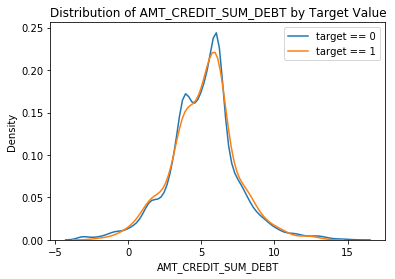

In [6]:
from math import log

target_sub = app_train[["TARGET", "SK_ID_CURR"]]
target_sub.index = target_sub["SK_ID_CURR"]
neg_debt = bureau[["AMT_CREDIT_SUM_DEBT", "SK_ID_CURR"]][bureau["AMT_CREDIT_SUM_DEBT"]<0]
neg_debt["AMT_CREDIT_SUM_DEBT"] = neg_debt["AMT_CREDIT_SUM_DEBT"].apply(lambda x: log(-1*x))
neg_debt.index = neg_debt["SK_ID_CURR"]
neg_debt = neg_debt.join(target_sub, on="SK_ID_CURR", lsuffix='_l', rsuffix='_r')
display(neg_debt)

sns.kdeplot(neg_debt.loc[neg_debt['TARGET'] == 0, "AMT_CREDIT_SUM_DEBT"], label = 'target == 0')
# # plot loans that were not repaid
sns.kdeplot(neg_debt.loc[neg_debt['TARGET'] == 1, "AMT_CREDIT_SUM_DEBT"], label = 'target == 1')

# # Label the plots
plt.title('Distribution of AMT_CREDIT_SUM_DEBT by Target Value')
plt.xlabel('AMT_CREDIT_SUM_DEBT'); plt.ylabel('Density');

AMT_CREDIT_SUM_DEBT的负值似乎对于TARGET值判断没什么帮助

对于这些有异常值的列，异常值均设为`np.nan`

In [9]:
at = data_sets["app_train"]
b = data_sets["bureau"]
at.loc[at["DAYS_EMPLOYED"]==365243, ["DAYS_EMPLOYED"]] = np.nan

for col in ["DAYS_CREDIT_UPDATE","DAYS_CREDIT_UPDATE"]:
    b.loc[b[col]<-365*100, [col]] = np.nan

for col in ["AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_ANNUITY"]:
    b.loc[np.abs(b[col])>30000000, [col]] = np.nan

print('app_train Features shape: ', at.shape)
print('app_test Features shape: ', app_test.shape)

app_train Features shape:  (307511, 243)
app_test Features shape:  (48744, 239)


训练集和测试集特征对齐：

In [10]:
train_labels = at['TARGET']
at, app_test = at.align(app_test, join = 'inner', axis = 1)
at['TARGET'] = train_labels
print('app_train Features shape: ', at.shape)
print('app_test Features shape: ', app_test.shape)

app_train Features shape:  (307511, 240)
app_test Features shape:  (48744, 239)


将object类型的特征转换为category类型能有效减少空间占用：

In [11]:
def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == np.int32:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [12]:
data_sets["app_test"] = app_test
data_sets["app_train"] = at
for ds_name, ds in data_sets.items():
    ds = convert_types(ds, True)
    ds.to_csv(ds_name + "_new.csv")
    print("%s conversion complete" % ds_name)

Original Memory Usage: 0.31 gb.
New Memory Usage: 0.21 gb.
app_train conversion complete
Original Memory Usage: 0.25 gb.
New Memory Usage: 0.17 gb.
bureau conversion complete
Original Memory Usage: 0.87 gb.
New Memory Usage: 0.76 gb.
bureau_balance conversion complete
Original Memory Usage: 0.05 gb.
New Memory Usage: 0.03 gb.
app_test conversion complete


接下来处理剩下的一些数据集，首先将前面的一些操作组合成一个方便的函数：

In [12]:
def prepocess_sets(data_sets):
    for ds_name, ds in data_sets.items():
        total_rows = ds.shape[0]
        null_count = 0
        to_del = []
        for col in ds.columns:
            if ds[col].isnull().sum()/total_rows > 0.95:
                print(col)
                to_del.append(col)
                null_count += 1
        
        if to_del:
            ds.drop(to_del, axis=1, inplace=True)

        print("%s columns of %s need to be dropped because of too many null values" % (null_count, ds_name))
        
    for ds_name, ds in data_sets.items():
        to_del = []
        one_value_count = 0
        for col in ds.columns:
            uv = ds[col].unique()
            if len(list(uv)) <= 1:
                print(col)
                to_del.append(col)
                one_value_count += 1
        if to_del:
            ds.drop(to_del, axis=1, inplace=True)

        print("%s columns of %s need to be dropped because of one unique values" % (one_value_count, ds_name))
        
    
    
    # Iterate through the columns
    for ds_name, ds in data_sets.items():
        le_count = 0
        le = LabelEncoder()
        cols = []
        for col in ds:
            if ds[col].dtype == 'object':
                # If 2 or fewer unique categories
                if len(list(ds[col].unique())) <= 2:
                    # Train on the training data
                    le.fit(ds[col])
                    # Transform both training and testing data
                    ds[col] = le.transform(ds[col])
                    # Keep track of how many columns were label encoded
                    le_count += 1

        print('%d columns of %s were label encoded.' % (le_count, ds_name))
        if cols:
            print(cols)
        
    for ds_name, ds in data_sets.items():
        data_sets[ds_name] = pd.get_dummies(ds)

        print('%s Features shape: ' % ds_name, ds.shape)
        
    return data_sets

In [13]:
cash = pd.read_csv('POS_CASH_balance.csv').reset_index(drop = True)
credit = pd.read_csv('credit_card_balance.csv').reset_index(drop = True)
previous = pd.read_csv('previous_application.csv').reset_index(drop = True)
installments = pd.read_csv('installments_payments.csv').reset_index(drop = True)

data_sets = dict(
                 cash=cash, 
                 credit=credit, previous=previous, installments=installments)

In [14]:
data_sets = prepocess_sets(data_sets)

0 columns of cash need to be dropped because of too many null values
0 columns of credit need to be dropped because of too many null values
RATE_INTEREST_PRIMARY
RATE_INTEREST_PRIVILEGED
2 columns of previous need to be dropped because of too many null values
0 columns of installments need to be dropped because of too many null values
0 columns of cash need to be dropped because of one unique values
0 columns of credit need to be dropped because of one unique values
0 columns of previous need to be dropped because of one unique values
0 columns of installments need to be dropped because of one unique values
0 columns of cash were label encoded.
0 columns of credit were label encoded.
1 columns of previous were label encoded.
0 columns of installments were label encoded.
cash Features shape:  (10001358, 8)
credit Features shape:  (3840312, 23)
previous Features shape:  (1670214, 35)
installments Features shape:  (13605401, 8)


In [17]:
count = 0
interested_dc = {}
for ds_name, ds in data_sets.items():
    if ds_name == "app_test":
        continue
    for col in ds:           
        no_na = ds[col].dropna()
        if col in ["TARGET"] or ds[col].dtype == 'object' or len(ds[col].unique())<=2 or no_na.between(0, 1).all():
            continue
        
        desc = ds[col].describe()
        iqr = abs(desc["25%"]-desc["75%"])
        if iqr == 0:
            continue
        upper = desc["75%"] + 1.5*iqr
        lower = desc["25%"] - 1.5*iqr
            
        abnorm = ~ds[col].between(lower, upper)
        if abnorm.any():
            if ds_name in interested_dc:
                interested_dc[ds_name].append(col)
            else:
                interested_dc[ds_name] = []
            count += 1
            print("-------------%s col %s-------------" % (ds_name, col))
            print(desc)
            print("-------------------------------------\n")
            
print(count)

-------------cash col CNT_INSTALMENT-------------
count    9.975287e+06
mean     1.708965e+01
std      1.199506e+01
min      1.000000e+00
25%      1.000000e+01
50%      1.200000e+01
75%      2.400000e+01
max      9.200000e+01
Name: CNT_INSTALMENT, dtype: float64
-------------------------------------

-------------cash col CNT_INSTALMENT_FUTURE-------------
count    9.975271e+06
mean     1.048384e+01
std      1.110906e+01
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      8.500000e+01
Name: CNT_INSTALMENT_FUTURE, dtype: float64
-------------------------------------

-------------credit col AMT_BALANCE-------------
count    3.840312e+06
mean     5.830016e+04
std      1.063070e+05
min     -4.202502e+05
25%      0.000000e+00
50%      0.000000e+00
75%      8.904669e+04
max      1.505902e+06
Name: AMT_BALANCE, dtype: float64
-------------------------------------

-------------credit col AMT_CREDIT_LIMIT_ACTUAL-------------
count    3.840312e+06
m

-------------installments col DAYS_ENTRY_PAYMENT-------------
count    1.360250e+07
mean    -1.051114e+03
std      8.005859e+02
min     -4.921000e+03
25%     -1.662000e+03
50%     -8.270000e+02
75%     -3.700000e+02
max     -1.000000e+00
Name: DAYS_ENTRY_PAYMENT, dtype: float64
-------------------------------------

-------------installments col AMT_INSTALMENT-------------
count    1.360540e+07
mean     1.705091e+04
std      5.057025e+04
min      0.000000e+00
25%      4.226085e+03
50%      8.884080e+03
75%      1.671021e+04
max      3.771488e+06
Name: AMT_INSTALMENT, dtype: float64
-------------------------------------

-------------installments col AMT_PAYMENT-------------
count    1.360250e+07
mean     1.723822e+04
std      5.473578e+04
min      0.000000e+00
25%      3.398265e+03
50%      8.125515e+03
75%      1.610842e+04
max      3.771488e+06
Name: AMT_PAYMENT, dtype: float64
-------------------------------------

30


其中有一些特征我们可能会感兴趣，我们结合其对应的target label来看一下：

In [3]:
interested_dc ={"previous":["SELLERPLACE_AREA", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]}
app_train = pd.read_csv("application_train.csv").reset_index(drop = True)

In [9]:
app_wanted_cols = ["TARGET", "SK_ID_CURR"]
for ds in interested_dc:
    for col in interested_dc[ds]:
        print("--------------ds %s col %s------------------" % (ds, col))
        now_col = data_sets[ds][col]
        desc = now_col.describe()
        iqr = abs(desc["25%"]-desc["75%"])
        if iqr == 0:
            continue
        upper = desc["75%"] + 1.5*iqr
        lower = desc["25%"] - 1.5*iqr
        
        max_v = now_col[now_col>=upper].max()
        min_v = now_col[now_col<=lower].min()
        
        print_flag = False
        if col.startswith("DAYS"):
            max_year = abs(max_v/365)
            min_year = abs(min_v/365)
            for v in [max_v, min_v]:
                y = abs(v/365)
                if y > 100:
                    print_flag = True
                    print("over 100 years for col %s: %s" % (col, v))
        else:
            print_flag = True
        
        if print_flag:
            interested_cols = interested_dc[ds]+["TARGET"] if "TARGET" in data_sets[ds].columns else interested_dc[ds]+["SK_ID_CURR"]
            if not np.isnan(max_v):
                wanted_data = data_sets[ds][now_col==max_v]
                print("-----------------max value--------------------")
                display(wanted_data[interested_cols])
                if ds != "app_train":
                    index = wanted_data["SK_ID_CURR"].tolist()
                    display(app_train[app_train["SK_ID_CURR"].isin(index)][app_wanted_cols])

            if not np.isnan(min_v):
                wanted_data = data_sets[ds][now_col==min_v]
                print("----------------min value--------------------")
                display(data_sets[ds][now_col==min_v][interested_cols])
                if ds != "app_train":
                    index = wanted_data["SK_ID_CURR"].tolist()
                    display(app_train[app_train["SK_ID_CURR"].isin(index)][app_wanted_cols])

--------------ds previous col SELLERPLACE_AREA------------------
-----------------max value--------------------


,SELLERPLACE_AREA,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,SK_ID_CURR
151,4000000,-960.0,-270.0,-360.0,-354.0,269324
157014,4000000,-723.0,-33.0,-33.0,-31.0,392616
310061,4000000,-452.0,238.0,365243.0,365243.0,450405
919667,4000000,-833.0,-143.0,-143.0,-141.0,228186
1427909,4000000,-348.0,-78.0,-78.0,-74.0,390387


,TARGET,SK_ID_CURR
110502,0,228186
146030,0,269324
250963,0,390387
252884,0,392616
302452,0,450405


--------------ds previous col DAYS_FIRST_DUE------------------
over 100 years for col DAYS_FIRST_DUE: 365243.0
-----------------max value--------------------


,SELLERPLACE_AREA,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,SK_ID_CURR
49,-1,365243.0,365243.0,365243.0,-171.0,200721
138,3000,365243.0,365243.0,365243.0,365243.0,205582
143,1500,365243.0,365243.0,365243.0,365243.0,276237
150,70,365243.0,344.0,365243.0,365243.0,248217
159,145,365243.0,365243.0,365243.0,365243.0,337203
225,-1,365243.0,365243.0,365243.0,365243.0,159650
333,30,365243.0,348.0,365243.0,365243.0,300401
360,3000,365243.0,573.0,365243.0,365243.0,423908
387,50,365243.0,351.0,365243.0,365243.0,321342
415,-1,365243.0,365243.0,365243.0,365243.0,263634


,TARGET,SK_ID_CURR
3,0,100006
17,0,100021
19,0,100023
21,0,100025
31,0,100036
40,1,100047
43,0,100050
51,0,100059
65,0,100077
71,0,100083


--------------ds previous col DAYS_LAST_DUE_1ST_VERSION------------------
over 100 years for col DAYS_LAST_DUE_1ST_VERSION: 365243.0
-----------------max value--------------------


,SELLERPLACE_AREA,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,SK_ID_CURR
17,6,-257.0,365243.0,365243.0,365243.0,142748
34,-1,-234.0,365243.0,365243.0,365243.0,255331
49,-1,365243.0,365243.0,365243.0,-171.0,200721
82,-1,-435.0,365243.0,365243.0,365243.0,342991
93,-1,-297.0,365243.0,365243.0,365243.0,120854
138,3000,365243.0,365243.0,365243.0,365243.0,205582
143,1500,365243.0,365243.0,365243.0,365243.0,276237
159,145,365243.0,365243.0,365243.0,365243.0,337203
225,-1,365243.0,365243.0,365243.0,365243.0,159650
242,100,-176.0,365243.0,365243.0,365243.0,396134


,TARGET,SK_ID_CURR
3,0,100006
8,0,100011
17,0,100021
19,0,100023
31,0,100036
36,0,100043
40,1,100047
41,0,100048
42,1,100049
43,0,100050


--------------ds previous col DAYS_LAST_DUE------------------
over 100 years for col DAYS_LAST_DUE: 365243.0
-----------------max value--------------------


,SELLERPLACE_AREA,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,SK_ID_CURR
1,-1,-134.0,916.0,365243.0,365243.0,108129
2,-1,-271.0,59.0,365243.0,365243.0,122040
17,6,-257.0,365243.0,365243.0,365243.0,142748
21,-1,-656.0,214.0,365243.0,365243.0,267782
34,-1,-234.0,365243.0,365243.0,365243.0,255331
44,182,-272.0,-2.0,365243.0,365243.0,118974
49,-1,365243.0,365243.0,365243.0,-171.0,200721
68,-1,-178.0,1592.0,365243.0,365243.0,197444
70,250,-99.0,171.0,365243.0,365243.0,372970
76,100,-3.0,147.0,365243.0,365243.0,404105


,TARGET,SK_ID_CURR
3,0,100006
4,0,100007
6,0,100009
10,0,100014
13,0,100017
14,0,100018
16,0,100020
17,0,100021
18,0,100022
19,0,100023


--------------ds previous col DAYS_TERMINATION------------------
over 100 years for col DAYS_TERMINATION: 365243.0
-----------------max value--------------------


,SELLERPLACE_AREA,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,SK_ID_CURR
1,-1,-134.0,916.0,365243.0,365243.0,108129
2,-1,-271.0,59.0,365243.0,365243.0,122040
17,6,-257.0,365243.0,365243.0,365243.0,142748
21,-1,-656.0,214.0,365243.0,365243.0,267782
34,-1,-234.0,365243.0,365243.0,365243.0,255331
44,182,-272.0,-2.0,365243.0,365243.0,118974
58,-1,-153.0,-3.0,-3.0,365243.0,283527
68,-1,-178.0,1592.0,365243.0,365243.0,197444
70,250,-99.0,171.0,365243.0,365243.0,372970
76,100,-3.0,147.0,365243.0,365243.0,404105


,TARGET,SK_ID_CURR
3,0,100006
4,0,100007
6,0,100009
8,0,100011
10,0,100014
13,0,100017
14,0,100018
16,0,100020
17,0,100021
18,0,100022


In [ ]:
SELLERPLACE_AREA是先前申请卖方的销售面积，有小于0的值。我们来看看负值对target有没有影响

0.0878182860135
0.0913430808565


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A1356D8>]], dtype=object)

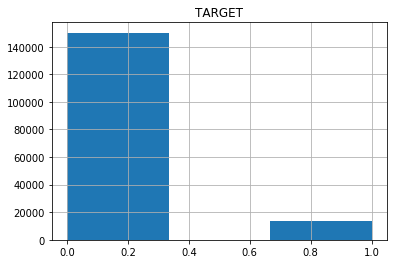

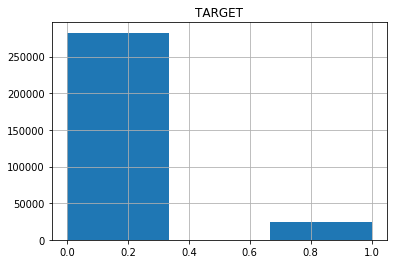

In [22]:
target_sub = app_train[["TARGET", "SK_ID_CURR"]]
target_sub.index=target_sub["SK_ID_CURR"]
one_zero = target_sub["TARGET"].value_counts()
print(one_zero[1]/one_zero[0])
# display(target_sub)
neg_area = previous[["SELLERPLACE_AREA", "SK_ID_CURR"]][previous["SELLERPLACE_AREA"]<0]
# neg_area = neg_area.reset_index(drop=True)
neg_area.index = neg_area["SK_ID_CURR"]

# display(neg_area)
neg_area = neg_area.join(target_sub, on=["SK_ID_CURR"], 
                         lsuffix='_l', rsuffix='_r'
                         , how="right"
                        )
neg_area.dropna(inplace=True)
neg_area.drop_duplicates(keep="first",inplace=True)
# display(neg_area)
one_zero = neg_area["TARGET"].value_counts()
print(one_zero[1]/one_zero[0])

neg_area.hist("TARGET", bins=3)
target_sub.hist("TARGET", bins=3)



SELLERPLACE_AREA的负值似乎对target有所影响，保留

同样，清理异常值，日期类替换大于0的，SELLERPLACE_AREA替换很大的异常值

In [15]:
b = data_sets["previous"]
# at.loc[at["DAYS_EMPLOYED"]==365243, ["DAYS_EMPLOYED"]] = np.nan

for col in ["DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]:
    b.loc[b[col]>365*100, [col]] = np.nan

for col in ["SELLERPLACE_AREA"]:
    b.loc[np.abs(b[col])>100000, [col]] = np.nan

In [16]:
for ds_name, ds in data_sets.items():
    ds = convert_types(ds, True)
    ds.to_csv(ds_name + "_new.csv")
    print("%s convert complete" % ds_name)

Original Memory Usage: 0.65 gb.
New Memory Usage: 0.49 gb.
cash convert complete
Original Memory Usage: 0.7 gb.
New Memory Usage: 0.44 gb.
credit convert complete
Original Memory Usage: 0.5 gb.
New Memory Usage: 0.37 gb.
previous convert complete
Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.
installments convert complete


清理一下内存，准备开始基线模型训练

In [23]:
import gc
gc.enable()
del app_test, app_train, cash, previous, bureau, bureau_balance, credit, installments, data_sets
gc.collect()

237

In [24]:
app_train = pd.read_csv("app_train_new.csv").reset_index(drop = True)
app_test = pd.read_csv("app_test_new.csv").reset_index(drop = True)



In [25]:
app_train = app_train.drop("Unnamed: 0", axis=1)
app_test = app_test.drop("Unnamed: 0", axis=1)

去除相关性大的列：

In [4]:
import random

def find_corr_feats(df):
    df = df.drop("SK_ID_CURR", axis=1)
    relation = df.corr()
    high_corr = {}
    del_cols = set()
    length = relation.shape[0]
    for i in range(length):
        if relation.columns[i] not in del_cols:
            for j in range(i+1,length):
                if (relation.iloc[i,j] > 0.97) and (relation.columns[j] not in del_cols): 
                    print("%s and %s: %s" % (relation.columns[i], relation.columns[j], relation.iloc[i,j]))
                    not_seen = True
                    if i in high_corr:
                        v = high_corr.pop(i)
                        high_corr.pop(v)
                        del_cols.add(i)
                        print("%s need to be deleted" % relation.columns[i])
                        not_seen = False
                    if j in high_corr:
                        v = high_corr.pop(j)
                        high_corr.pop(v)
                        del_cols.add(j)
                        print("%s need to be deleted" % relation.columns[j])
                        not_seen = False
                    if not_seen:
                        high_corr[i] = j
                        high_corr[j] = i
    remain = []
    keys = list(high_corr.keys())
    for k in keys:
        if k in high_corr:
            v = high_corr.pop(k)
            high_corr.pop(v)
            remain.append(random.choice([k, v]))
    return [relation.columns[i] for i in list(del_cols)+remain]

In [5]:
to_del_cols = find_corr_feats(app_train)
print(to_del_cols)

AMT_CREDIT and AMT_GOODS_PRICE: 0.9869683054228436
APARTMENTS_AVG and APARTMENTS_MODE: 0.973259462803817
APARTMENTS_AVG and APARTMENTS_MEDI: 0.9950808157846184
APARTMENTS_AVG need to be deleted
BASEMENTAREA_AVG and BASEMENTAREA_MODE: 0.9734957847240284
BASEMENTAREA_AVG and BASEMENTAREA_MEDI: 0.9943173374935921
BASEMENTAREA_AVG need to be deleted
YEARS_BEGINEXPLUATATION_AVG and YEARS_BEGINEXPLUATATION_MODE: 0.9718933679491143
YEARS_BEGINEXPLUATATION_AVG and YEARS_BEGINEXPLUATATION_MEDI: 0.9938254174586915
YEARS_BEGINEXPLUATATION_AVG need to be deleted
YEARS_BUILD_AVG and YEARS_BUILD_MODE: 0.9894439220012607
YEARS_BUILD_AVG and YEARS_BUILD_MEDI: 0.9984946631418847
YEARS_BUILD_AVG need to be deleted
COMMONAREA_AVG and COMMONAREA_MODE: 0.9771470919973959
COMMONAREA_AVG and COMMONAREA_MEDI: 0.9959780551012081
COMMONAREA_AVG need to be deleted
ELEVATORS_AVG and ELEVATORS_MODE: 0.9788372819966512
ELEVATORS_AVG and ELEVATORS_MEDI: 0.9960994428264447
ELEVATORS_AVG need to be deleted
ENTRANCES_A

In [26]:
to_del_cols = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'AMT_GOODS_PRICE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE_XNA']

app_train = app_train.drop(to_del_cols, axis=1)
app_test = app_test.drop(to_del_cols, axis=1)

去除相关性较大的列后，用lightGBM做预测作为基线模型：

In [41]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import roc_auc_score


from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import roc_auc_score
import gc



def model(train, test, cat_indices="auto", n_folds = 5, parallel=2):
    train_ids = train['SK_ID_CURR']
    test_ids = test['SK_ID_CURR']
    test = test.drop(['SK_ID_CURR'] , axis=1)
    y = train["TARGET"]
    X = train.drop(["TARGET",'SK_ID_CURR'] , axis=1)
    feature_names = list(X.columns)
    
    k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test.shape[0])
    out_of_fold = np.zeros(X.shape[0])
    
    valid_scores = []
    train_scores = []
    best_iteration = 2000
    for train_indices, valid_indices in k_fold.split(X):

        # Training data for the fold
        tnX, tny = X.loc[train_indices, :], y[train_indices]
        # Validation data for the fold
        vX, vy = X.loc[valid_indices, :], y[valid_indices]
        
        lgbm = LGBMClassifier(n_estimators=2000, objective = 'binary', 
                              learning_rate = 0.05, n_jobs = parallel, random_state = 50,
                              subsample=0.8, reg_alpha = 0.1, reg_lambda = 0.1, class_weight="balanced"
                             )

        lgbm.fit(tnX, tny, eval_metric="auc", categorical_feature = cat_indices, feature_name= 'auto',
                 eval_set = [(vX, vy), (tnX, tny)], eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 200)
        test_predictions += lgbm.predict_proba(test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        best_iteration = lgbm.best_iteration_
        feature_importance_values += lgbm.feature_importances_ / k_fold.n_splits
        out_of_fold[valid_indices] = lgbm.predict_proba(vX, num_iteration = best_iteration)[:, 1]
        
        valid_scores.append(lgbm.best_score_['valid']['auc'])
        train_scores.append(lgbm.best_score_['train']['auc'])
        
        gc.enable()
        del lgbm, tnX, vX
        gc.collect()
    
    print("----------------------------training finished---------------------------")
    print("best iteration:", best_iteration)
#     print(feature_importance_values)

    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(y, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics


In [14]:
set(app_train.columns) - set(app_test.columns)

{'CODE_GENDER_XNA',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_INCOME_TYPE_Maternity leave',
 'TARGET'}

In [42]:
cat_feats = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
submission, fi, metrics = model(app_train, app_test, cat_feats)
print('Baseline metrics')
print(metrics)

c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.550926	train's auc: 0.79542	valid's binary_logloss: 0.566184	valid's auc: 0.752412
Early stopping, best iteration is:
[280]	train's binary_logloss: 0.538907	train's auc: 0.80774	valid's binary_logloss: 0.558721	valid's auc: 0.752924


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.551201	train's auc: 0.795392	valid's binary_logloss: 0.566402	valid's auc: 0.754992
Early stopping, best iteration is:
[211]	train's binary_logloss: 0.549316	train's auc: 0.797367	valid's binary_logloss: 0.565228	valid's auc: 0.755186


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.551833	train's auc: 0.794899	valid's binary_logloss: 0.56694	valid's auc: 0.75957
Early stopping, best iteration is:
[197]	train's binary_logloss: 0.55233	train's auc: 0.794381	valid's binary_logloss: 0.56723	valid's auc: 0.759644


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.550902	train's auc: 0.795767	valid's binary_logloss: 0.565187	valid's auc: 0.754731
Early stopping, best iteration is:
[231]	train's binary_logloss: 0.545712	train's auc: 0.80106	valid's binary_logloss: 0.562051	valid's auc: 0.755112


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.55131	train's auc: 0.795039	valid's binary_logloss: 0.567276	valid's auc: 0.755126
[400]	train's binary_logloss: 0.522743	train's auc: 0.824399	valid's binary_logloss: 0.549807	valid's auc: 0.754909
Early stopping, best iteration is:
[326]	train's binary_logloss: 0.532528	train's auc: 0.814388	valid's binary_logloss: 0.555737	valid's auc: 0.755627
----------------------------training finished---------------------------
best iteration: 326
Baseline metrics
      fold     train     valid
0        0  0.807740  0.752924
1        1  0.797367  0.755186
2        2  0.794381  0.759644
3        3  0.801060  0.755112
4        4  0.814388  0.755627
5  overall  0.802987  0.755648


转换成提交csv格式，上传到kaggle，auc大概是0.74065

In [43]:
submission.to_csv('baseline_lgb.csv', index = False)

In [ ]:
forward feature selection using just Ridge regression.降维